In [1]:
import pandas as pd
import numpy as np
import umap
from matplotlib import pyplot as plt
from matplotlib import colors

In [2]:
games=pd.read_csv('./games.csv')

In [3]:
## Define cols to use
num_cols = [
    'turns',
    'white_rating',
    'black_rating',
    'opening_ply'
]

In [4]:
## Filter dataset
num_games = games[num_cols]

In [25]:
## Instantiate model
reducer = umap.UMAP(metric='cosine')

In [26]:
## Train the model
embedding = reducer.fit_transform(num_games)

<ipython-input-27-471f0e81af73>:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  plt.scatter(embedding[:,0],


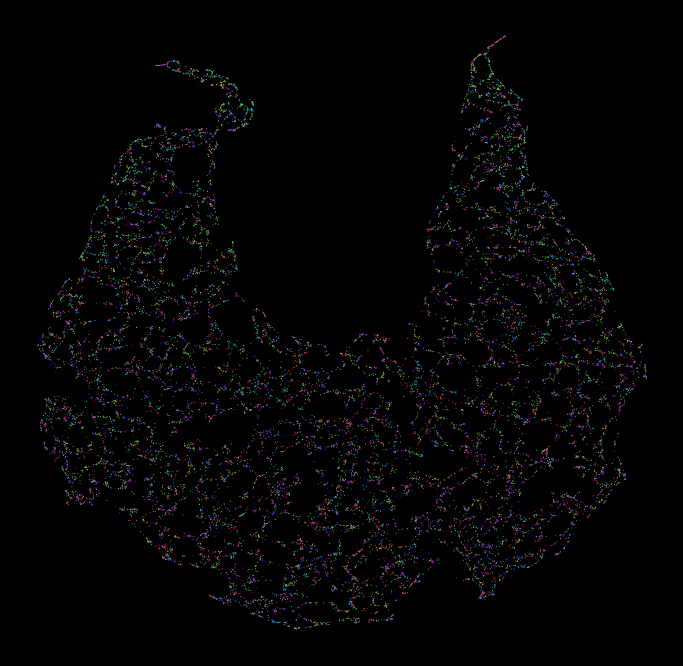

In [27]:
## Render vis
fig = plt.figure(figsize=(12,12))
fig.patch.set_facecolor('black')

plt.scatter(embedding[:,0], 
            embedding[:,1], 
            marker='o', 
            s=1, 
            edgecolor='',
            c=np.arange(num_games.shape[0]), 
            cmap='hsv', alpha=1)

plt.axis("off")
# plt.plot(dpi=300)
plt.savefig("num_games.png", dpi=600, facecolor='black')